In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import talib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from LorentzianClassification.Classfier import LorentzianClassification

# Data Preparation

In [8]:
# List of currency pairs
currency_pairs = ["AUDUSD=X", "NZDUSD=X", "USDBRL=X", "USDCAD=X", "USDNOK=X", "USDZAR=X", 'USDJPY=X']

# Start & End Date
start_date = '1993-01-01'
end_date = '2023-01-01'

# Function to fetch exchange rate
def get_exchange_rate(currency_pairs ,start, end):
    price = yf.download(currency_pairs, start=start, end=end, group_by='ticker', interval='1d')
    return price

In [9]:
FX_df = get_exchange_rate(currency_pairs, start_date, end_date)

# Flatten MultiIndex columns
FX_df.columns = ['_'.join(col).strip() for col in FX_df.columns.values]

[*********************100%***********************]  7 of 7 completed


In [10]:
pair_dict = {}
for pair in currency_pairs:
    pair_data = FX_df[[col for col in FX_df.columns if col.startswith(pair)]]
    pair_data.columns = [col.split('_')[1] for col in pair_data.columns]  # Remove ticker from column names
    pair_data = pair_data.dropna()
    pair_dict[pair] = pair_data

In [11]:
currency_pairs

['AUDUSD=X',
 'NZDUSD=X',
 'USDBRL=X',
 'USDCAD=X',
 'USDNOK=X',
 'USDZAR=X',
 'USDJPY=X']

# Lorentzian Classification Predictions

In [12]:
lc = LorentzianClassification(pair_dict['USDCAD=X'])

# lc = LorentzianClassification(
#         pair_dict['USDJPY=X'],
#         features=[
#             LorentzianClassification.Feature("RSI", 14, 2),  # f1
#             LorentzianClassification.Feature("WT", 10, 11),  # f2
#             LorentzianClassification.Feature("CCI", 20, 2),  # f3
#             LorentzianClassification.Feature("ADX", 20, 2),  # f4
#             LorentzianClassification.Feature("RSI", 9, 2),   # f5
#         ],
#         settings=LorentzianClassification.Settings(
#             source=pair_dict['USDJPY=X'].Close,
#             neighborsCount=8,
#             maxBarsBack=8000,
#             useDynamicExits=False
#         ),
#         filterSettings=LorentzianClassification.FilterSettings(
#             useVolatilityFilter=True,
#             useRegimeFilter=True,
#             useAdxFilter=False,
#             regimeThreshold=-0.1,
#             adxThreshold=20,
#             kernelFilter = LorentzianClassification.KernelFilter(
#                 useKernelSmoothing = False,
#                 lookbackWindow = 8,
#                 relativeWeight = 8.0,
#                 regressionLevel = 25,
#                 crossoverLag = 1,
#             )
#         ))

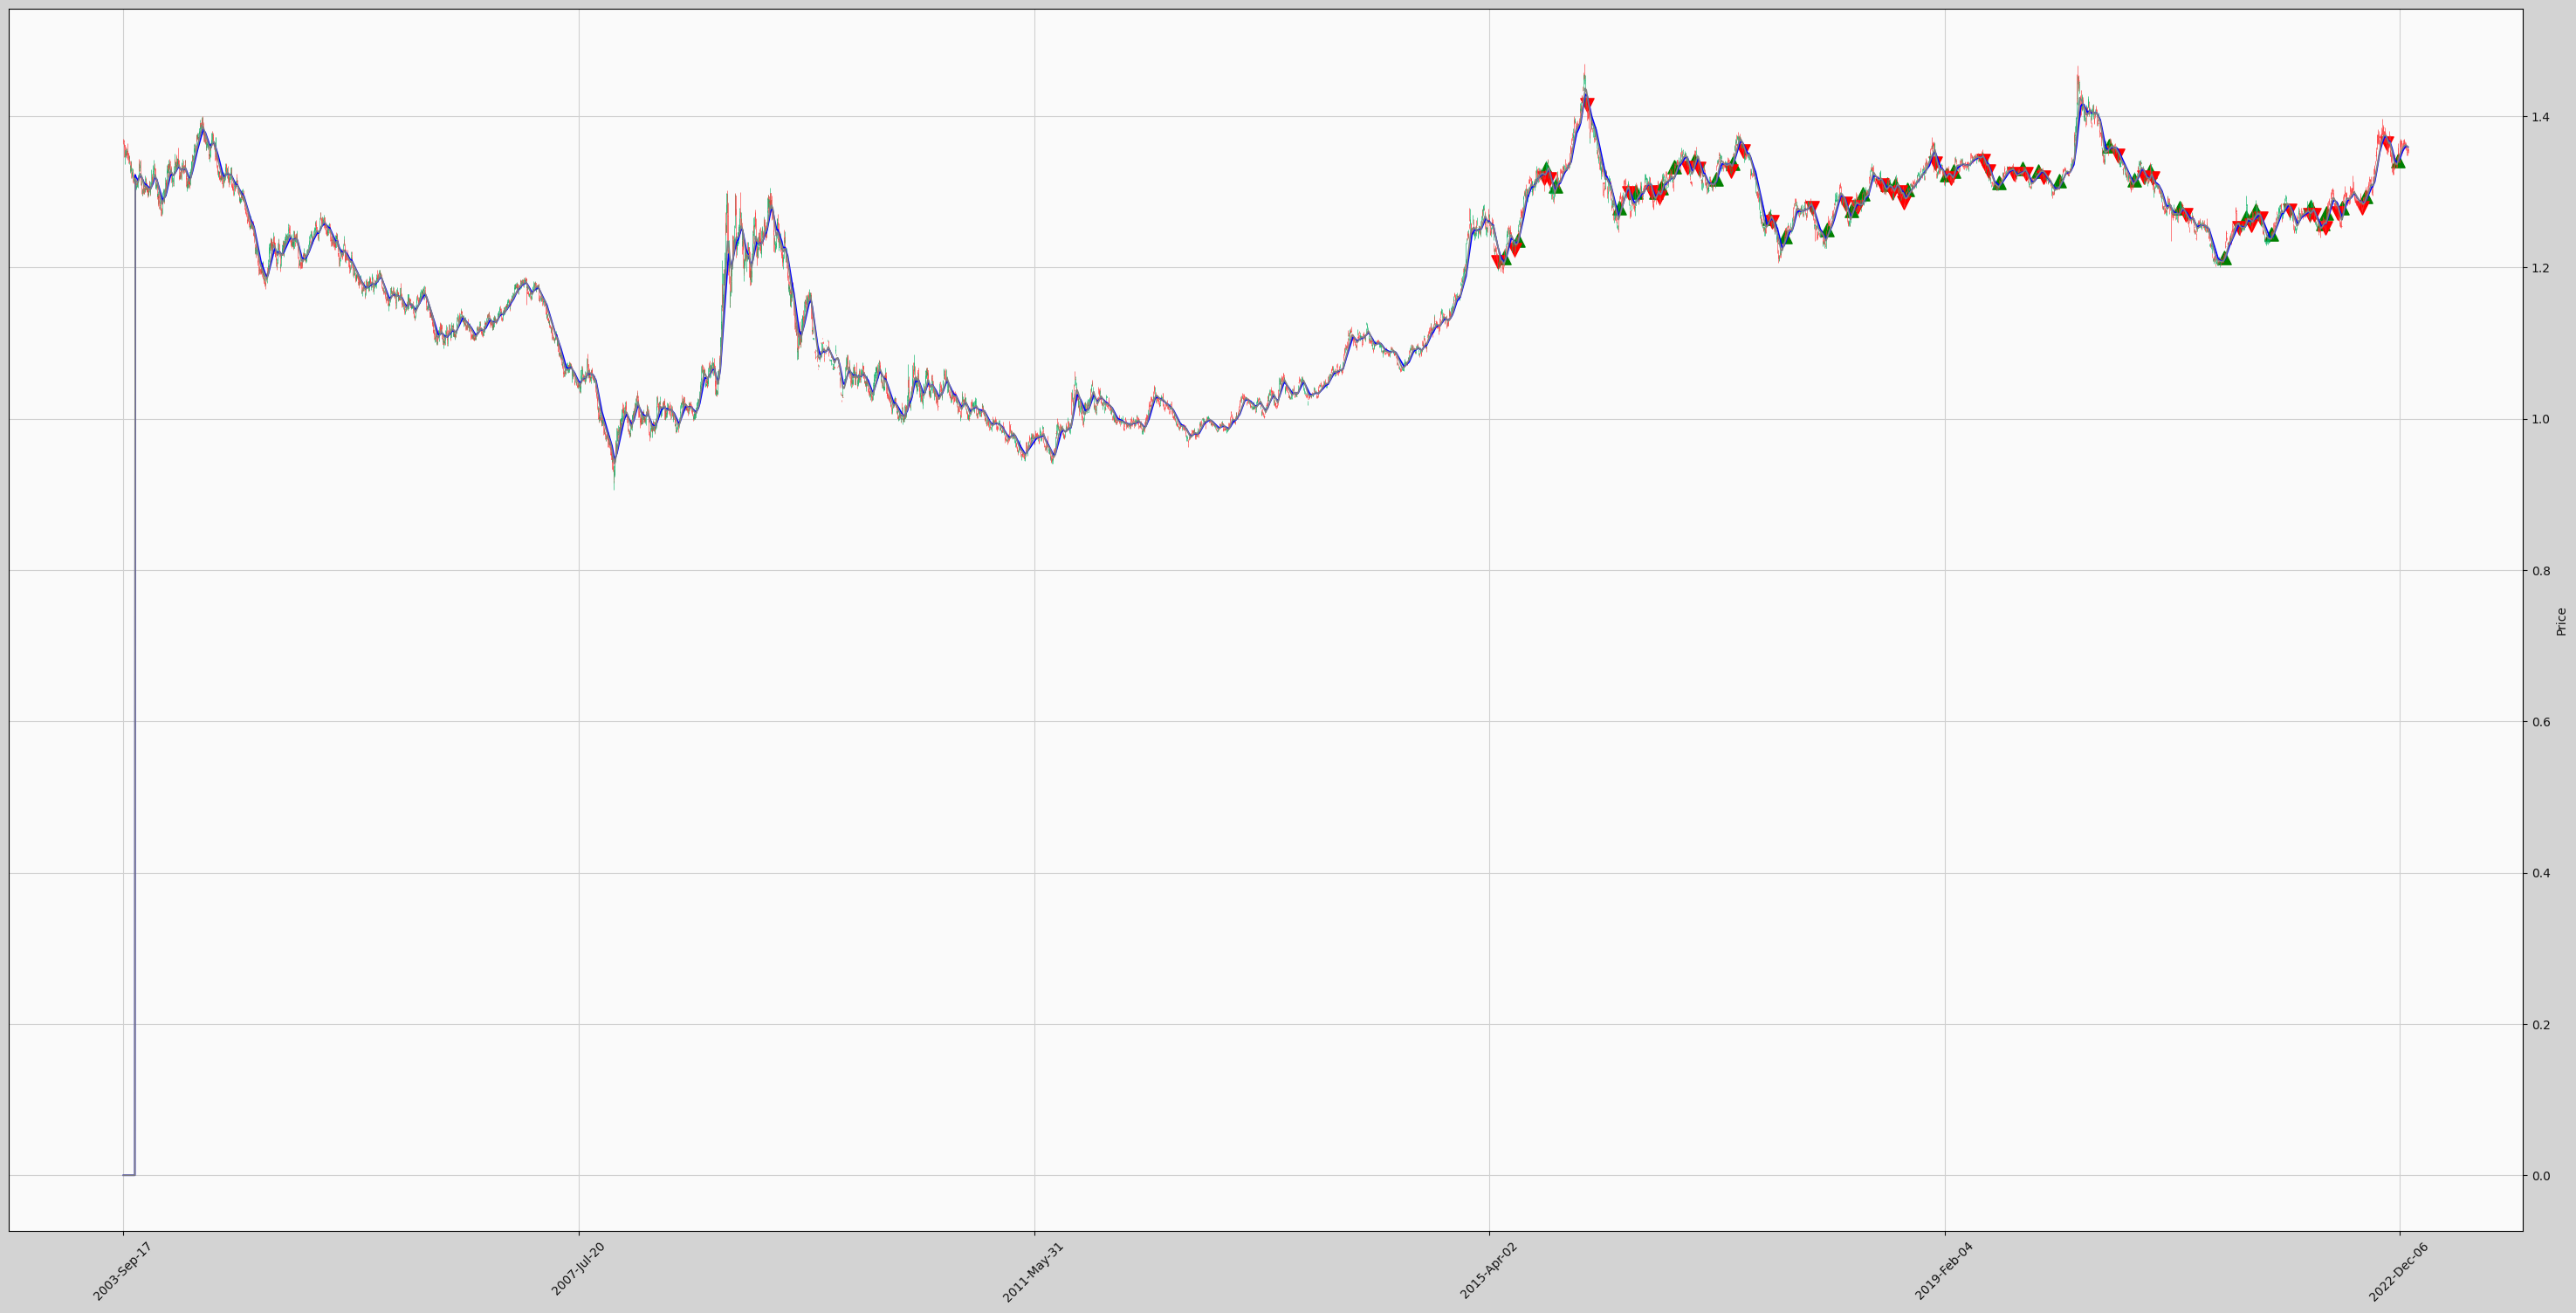

In [13]:
lc.plot()

# Backtesting

In [370]:
from backtesting import Backtest, Strategy

In [371]:
lc_df_all = lc.df.copy()
lc_df_all['yhat1'] = lc.yhat1

In [372]:
# Signals from LC model
def startLong():
    return lc_df_all.startLongTrade
def endLong():
    return lc_df_all.endLongTrade
def startShort():
    return lc_df_all.startShortTrade
def endShort():
    return lc_df_all.endShortTrade
def turning():
    return lc_df_all.yhat1
def grad():
    return np.gradient(lc_df_all.yhat1)

In [373]:
class LCStrategy(Strategy):
    def init(self):
        super().init()
        self.startlong = self.I(startLong)
        self.startshort = self.I(startShort)
        self.turning = self.I(turning)
        self.grad = self.I(turning)
        self.grad = np.gradient(self.grad)
    def next(self):
        super().next()
        if self.startlong > 0 :
            self.buy()
        elif self.startshort > 0 :
            self.sell()
        
        
        # Check if the number of bars since entry has reached 4
        if self.grad[-1] < 0 and self.position.is_long:
            self.position.close() 
        elif self.grad[-1] > 0 and self.position.is_short:
            self.position.close()  

In [374]:
bt = Backtest(lc_df_all, LCStrategy, cash=10000, commission=0.002, trade_on_close=False)

In [375]:
stats = bt.run()
stats

Start                     2003-09-17 00:00:00
End                       2022-12-30 00:00:00
Duration                   7044 days 00:00:00
Exposure Time [%]                    27.13688
Equity Final [$]                  9554.800752
Equity Peak [$]                  12301.848588
Return [%]                          -4.451992
Buy & Hold Return [%]               -0.841443
Return (Ann.) [%]                   -0.228398
Volatility (Ann.) [%]                3.648344
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.160987
Avg. Drawdown [%]                   -2.196988
Max. Drawdown Duration     1747 days 00:00:00
Avg. Drawdown Duration      105 days 00:00:00
# Trades                                   79
Win Rate [%]                        35.443038
Best Trade [%]                       8.596639
Worst Trade [%]                     -2.346753
Avg. Trade [%]                    

In [376]:
bt.plot()

GridPlot(id='p11449', ...)

**Observations**
- model does not seem to work well in range-bound market --> is this an issue of tweaking the time ranges of the input variables?
- may need more conditions to achieve a better entry or exit point
- **TO VET**: To check if python implementation vs. original is correct. python implementation was copied over to another folder instead of pip install as there were errors with the implementation online. Check Classifier.py line 268 vs. original https://www.tradingview.com/script/WhBzgfDu-Machine-Learning-Lorentzian-Classification/ line 324. Model is supposed to predict direction in next 4 bars but the shifting from python implementation looks suspicious